# Etapa 1: Biblioteca e Dados
 



In [20]:
#!pip install skorch

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import skorch
import torch
import torch.nn as nn


# Etapa 2: Dados

In [2]:
# setando semente aleatória
np.random.seed(123)
torch.manual_seed(123)

In [4]:
previsores = pd.read_csv('entradas_breast.csv')
classe = pd.read_csv('saidas_breast.csv')

In [5]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [6]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


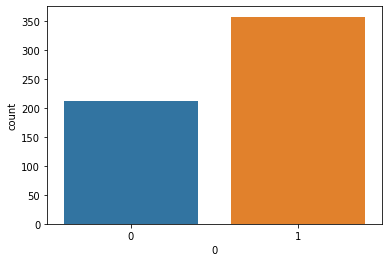

In [7]:
sns.countplot(x= classe['0']);

In [8]:
previsores.shape

(569, 30)

In [9]:
classe.shape

(569, 1)

In [10]:
# Convertendo os dados em Numpy float32 (formato utilizado pelo ??)

previsores = np.array(previsores, dtype='float32')
classe = np.array(classe, dtype='float32').squeeze(1)

In [11]:
classe.shape

(569,)

In [12]:
print(type(previsores), type(classe))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Etapa 3: Criando a classe do classificador

In [13]:

# para realizar o cross_val com skorch precisamos de uma classe que herda de nn.Module da pytorch
class ClassificadorTorch(nn.Module):
  # Definindo construtor com os atributos da classe 
    def __init__(self):
        super().__init__()
        # Primeira camada densa 30 inputs 16 outputs 1a funcao de ativacão ReLU
        self.dense0 = nn.Linear(30,16)
        torch.nn.init.uniform_(self.dense0.weight) # Atribuindo inicializacão aleatória em distribuição uniform ao atributo pesos da primeira camada
        self.activation0 = nn.ReLU()
        # Segunda camada densa 16 inputs 16 outputs 2a funcao de ativacão ReLU
        self.dense1 = nn.Linear(16,16)
        torch.nn.init.uniform_(self.dense1.weight)
        self.activation1 = nn.ReLU()
        # Camada de saída densa 16 inputs 1 outputs + funcao de ativacão Sigmoid
        self.dense2 = nn.Linear(16,1)
        torch.nn.init.uniform_(self.dense2.weight)
        #self.output = nn.Sigmoid() ** descontinuada na sktorch


    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        #X = self.output(X)

        return X




In [14]:
# Converte o classificador para um objeto compatível do sklearn
## Passamos a classe pytorch(herdana da Classe nn.Module)
## Função de perda Binary cross entropy
## e não seperar train_test, pois faremos isso na cross_val

classificador_sklearn = skorch.NeuralNetBinaryClassifier(module = ClassificadorTorch,
                                                         criterion=nn.BCEWithLogitsLoss,
                                                         optimizer = torch.optim.Adam,
                                                         lr = 0.001,
                                                         optimizer__weight_decay= 0.0001,
                                                         max_epochs =100,
                                                         batch_size = 10,
                                                         train_split=False)

In [15]:

np.isnan(previsores).sum()
np.isnan(classe).sum()

0

# Etapa 5: Validação Cruzada

In [16]:



resultados = cross_val_score(classificador_sklearn,
                             previsores,
                             classe,
                             cv = 10,
                             scoring='accuracy'
                             )

  epoch    train_loss     dur
-------  ------------  ------
      1   107325.7548  0.0760
      2    86254.6312  0.0420
      3    68469.2033  0.0460
      4    53957.7559  0.0429
      5    42087.0212  0.0460
      6    32326.2669  0.0470
      7    24257.5124  0.0410
      8    17518.0696  0.0420
      9    11790.4194  0.0410
     10     6781.5143  0.0400
     11     2218.8347  0.0430
     12      192.7409  0.0420
     13      166.0526  0.0440
     14      142.9379  0.0430
     15      125.7540  0.0410
     16      106.8138  0.0400
     17       91.0752  0.0410
     18       85.3524  0.0420
     19       76.0445  0.0410
     20       69.1575  0.0420
     21       65.6259  0.0420
     22       50.4494  0.0440
     23       50.1384  0.0430
     24       48.4084  0.0420
     25       48.6808  0.0440
     26       45.4503  0.0420
     27       44.8298  0.0450
     28       48.2071  0.0460
     29       41.6401  0.0440
     30       40.3258  0.0440
     31       36.1550  0.0420
     32   

In [17]:
resultados

array([0.78947368, 0.84210526, 0.8245614 , 0.94736842, 0.89473684,
       0.87719298, 0.8245614 , 0.92982456, 0.84210526, 0.78571429])

In [19]:
resultados.mean()

0.8557644110275688

In [20]:
resultados.std()

0.05241766410264723

# Dropout

In [23]:
class Classificador_Dropout(nn.Module):
  # estrutura: 30 > 16 > ReLU > dropout > 16 > ReLU > dropout > 1 

    ## Definindo os atributos da classe
    def __init__(self):
        super().__init__()

        self.dense0 = nn.Linear(30,16)
        torch.nn.init.uniform_(self.dense0.weight)
        self.activation0 = nn.ReLU()
        self.dropout0 = nn.Dropout(p=0.2)
        self.dense1 = nn.Linear(16,16)
        torch.nn.init.uniform_(self.dense1.weight)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p = 0.2)
        self.dense2 = nn.Linear(16,1)
        torch.nn.init.uniform_(self.dense2.weight)

    def forward(self, X):

        # Define o método de aplicação do forward no conjunto de dados

        X = self.dense0(X)
        X = self.activation0(X)
        X = self.dropout0(X)
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dropout1(X)
        X = self.dense2(X)

        return X







   
  



In [24]:

classificador_sklearn_dropout = skorch.NeuralNetBinaryClassifier(
    module = Classificador_Dropout,
    criterion= nn.BCEWithLogitsLoss,
    optimizer = torch.optim.Adam,
    lr =0.001,
    optimizer__weight_decay = 0.0001,
    max_epochs=100,
    batch_size=10,
    train_split=False

)

In [25]:
resultados = cross_val_score(classificador_sklearn_dropout,
                             X=previsores,
                             y=classe,
                             cv = 10,
                             scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    76826.3913  0.0500
      2    60939.8435  0.0460
      3    48414.3302  0.0460
      4    36653.4977  0.0460
      5    28375.0040  0.0450
      6    21817.1027  0.0470
      7    16252.4864  0.0510
      8    11266.8606  0.0440
      9     7430.2988  0.0450
     10     4148.7801  0.0430
     11     2851.8538  0.0440
     12     2349.3630  0.0430
     13     2574.3616  0.0440
     14     2280.8979  0.0440
     15     1909.6452  0.0430
     16     1792.1117  0.0430
     17     1636.7897  0.0440
     18     1475.0408  0.0430
     19     1628.6916  0.0420
     20     1758.2287  0.0430
     21     1512.2897  0.0430
     22     1185.2868  0.0430
     23     1009.3950  0.0450
     24     1060.6704  0.0480
     25     1212.9754  0.0500
     26      966.5797  0.0460
     27      882.4843  0.0450
     28      844.1318  0.0440
     29      831.6537  0.0439
     30      682.7000  0.0460
     31      725.7149  0.0450
     32   

In [26]:
resultados

array([0.68421053, 0.54385965, 0.59649123, 0.66666667, 0.68421053,
       0.61403509, 0.43859649, 0.63157895, 0.45614035, 0.82142857])

In [61]:
media = resultados.mean()
desvio = resultados.std()

media, desvio

(0.6239348370927319, 0.12148597694882249)